### Training Neural Networks

#### Losses in PyTorch

Let's start by seeing how we calculate the loss with PyTorch. Through the `nn` module, PyTorch provides losses such as the cross-entropy loss (`nn.CrossEntropyLoss`). You'll usually see the loss assigned to `criterion`. As noted in the last part, with a classification problem such as MNIST, we're using the softmax function to predict class probabilities. With a softmax output, you want to use cross-entropy as the loss. To actually calculate the loss, you first define the criterion then pass in the output of your network and the correct labels.

Something really important to note here. Looking at [the documentation for `nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss),

> This criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.
>
> The input is expected to contain scores for each class.

This means we need to pass in the raw output of our network into the loss, not the output of the softmax function. This raw output is usually called the *logits* or *scores*. We use the logits because softmax gives you probabilities which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one ([read more here](https://docs.python.org/3/tutorial/floatingpoint.html)). It's usually best to avoid doing calculations with probabilities, typically we use log-probabilities.

In [2]:
# The MNIST datasets are hosted on yann.lecun.com that has moved under CloudFlare protection
# Run this script to enable the datasets download
# Reference: https://github.com/pytorch/vision/issues/1938

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [11]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [13]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

# Define the loss
criterion = nn.CrossEntropyLoss()

# Get our data
dataiter = iter(trainloader)

images, labels = next(dataiter)

# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)

# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.2823, grad_fn=<NllLossBackward0>)


In my experience it's more convenient to build the model with a log-softmax output using `nn.LogSoftmax` or `F.log_softmax` ([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.LogSoftmax)). Then you can get the actual probabilities by taking the exponential `torch.exp(output)`. With a log-softmax output, you want to use the negative log likelihood loss, `nn.NLLLoss` ([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.NLLLoss)).

In [16]:
# Build a feed-forward network
modoel = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim=1)
)

# Define the loss
criterion = nn.NLLLoss()

# Get our data
dataiter = iter(trainloader)

images, labels = next(dataiter)

# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)

loss = criterion(logits, labels)
print(loss)

tensor(0.0327, grad_fn=<NllLossBackward0>)


#### Autograd

Now that we know how to calculate a loss, how do we use it to perform backpropagation? Torch provides a module, `autograd`, for automatically calculating the gradients of tensors. We can use it to calculate the gradients of all our parameters with respect to the loss. Autograd works by keeping track of operations performed on tensors, then going backwards through those operations, calculating gradients along the way. To make sure PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set `requires_grad = True` on a tensor. You can do this at creation with the `requires_grad` keyword, or at any time with `x.requires_grad_(True)`.

You can turn off gradients for a block of code with the `torch.no_grad()` content:
```python
x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False
```

Also, you can turn on or off gradients altogether with `torch.set_grad_enabled(True|False)`.

The gradients are computed with respect to some variable `z` with `z.backward()`. This does a backward pass through the operations that created `z`.

In [29]:
x = torch.randn(2, 2, requires_grad=True)
print(x)

tensor([[0.5426, 0.1374],
        [1.8897, 0.4720]], requires_grad=True)


In [30]:
y = x ** 2
print(y)

tensor([[0.2944, 0.0189],
        [3.5709, 0.2228]], grad_fn=<PowBackward0>)


In [31]:
## grad_fn shows the function that generated this variable
print(y.grad_fn)

In [32]:
z = y.mean()
print(z)

tensor(1.0268, grad_fn=<MeanBackward0>)


In [33]:
print(x.grad)

None


To calculate the gradients, you need to run the `.backward` method on a Variable, `z` for example. This will calculate the gradient for `z` with respect to `x`

$$
\frac{\partial z}{\partial x} = \frac{\partial}{\partial x}\left[\frac{1}{n}\sum_i^n x_i^2\right] = \frac{x}{2}
$$

In [34]:
z.backward()
print(x.grad)
print(x/2)

tensor([[0.2713, 0.0687],
        [0.9448, 0.2360]])
tensor([[0.2713, 0.0687],
        [0.9448, 0.2360]], grad_fn=<DivBackward0>)


These gradients calculations are particularly useful for neural networks. For training we need the gradients of the cost with respect to the weights. With PyTorch, we run data forward through the network to calculate the loss, then, go backwards to calculate the gradients with respect to the loss. Once we have the gradients we can make a gradient descent step. 

#### Loss and Autograd together

When we create a network with PyTorch, all of the parameters are initialized with `requires_grad = True`. This means that when we calculate the loss and call `loss.backward()`, the gradients for the parameters are calculated. These gradients are used to update the weights with gradient descent. Below you can see an example of calculating the gradients using a backwards pass.

In [35]:
# Build a feed-forward network
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim=1)
)

criterion = nn.NLLLoss()
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)

In [36]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
        [-0.0036, -0.0036, -0.0036,  ..., -0.0036, -0.0036, -0.0036],
        [-0.0005, -0.0005, -0.0005,  ..., -0.0005, -0.0005, -0.0005],
        ...,
        [-0.0022, -0.0022, -0.0022,  ..., -0.0022, -0.0022, -0.0022],
        [ 0.0005,  0.0005,  0.0005,  ...,  0.0005,  0.0005,  0.0005],
        [-0.0018, -0.0018, -0.0018,  ..., -0.0018, -0.0018, -0.0018]])


#### Training the network

There's one last piece we need to start training, an optimizer that we'll use to update the weights with the gradients. We get these from PyTorch's [`optim` package](https://pytorch.org/docs/stable/optim.html). For example we can use stochastic gradient descent with `optim.SGD`. You can see how to define an optimizer below.

In [37]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

Now we know how to use all the individual parts so it's time to see how they work together. Let's consider just one learning step before looping through all the data. The general process with PyTorch:

* Make a forward pass through the network 
* Use the network output to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

Below I'll go through one training step and print out the weights and gradients so you can see how it changes. Note that I have a line of code `optimizer.zero_grad()`. When you do multiple backwards passes with the same parameters, the gradients are accumulated. This means that you need to zero the gradients on each training pass or you'll retain gradients from previous training batches.

In [39]:
print(f'Initial weigths - {model[0].weight}')

dataiter = iter(trainloader)
images, labels = next(dataiter)
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images)
loss = criterion(output, labels)
loss.backward()
print(f'Gradient - {model[0].weight.grad}')

Initial weigths - Parameter containing:
tensor([[-0.0165,  0.0227, -0.0027,  ..., -0.0267, -0.0134, -0.0180],
        [ 0.0198, -0.0082, -0.0348,  ..., -0.0256, -0.0299,  0.0149],
        [-0.0158, -0.0077,  0.0248,  ...,  0.0135, -0.0270, -0.0329],
        ...,
        [ 0.0102, -0.0114,  0.0183,  ..., -0.0110, -0.0147,  0.0179],
        [-0.0266, -0.0233, -0.0134,  ...,  0.0234, -0.0353, -0.0345],
        [-0.0204,  0.0024, -0.0177,  ..., -0.0323, -0.0100,  0.0171]],
       requires_grad=True)
Gradient - tensor([[ 2.3032e-03,  2.3032e-03,  2.3032e-03,  ...,  2.3032e-03,
          2.3032e-03,  2.3032e-03],
        [-5.8620e-03, -5.8620e-03, -5.8620e-03,  ..., -5.8620e-03,
         -5.8620e-03, -5.8620e-03],
        [ 5.8195e-05,  5.8195e-05,  5.8195e-05,  ...,  5.8195e-05,
          5.8195e-05,  5.8195e-05],
        ...,
        [-5.8433e-03, -5.8433e-03, -5.8433e-03,  ..., -5.8432e-03,
         -5.8432e-03, -5.8432e-03],
        [ 1.3984e-03,  1.3984e-03,  1.3984e-03,  ...,  1.3984e-

In [40]:
# Take an update step and view the new weights
optimizer.step()
print(f'Updated weights - {model[0].weight}')

Updated weights - Parameter containing:
tensor([[-0.0165,  0.0227, -0.0027,  ..., -0.0267, -0.0135, -0.0180],
        [ 0.0199, -0.0081, -0.0347,  ..., -0.0255, -0.0299,  0.0149],
        [-0.0158, -0.0077,  0.0248,  ...,  0.0135, -0.0270, -0.0329],
        ...,
        [ 0.0103, -0.0114,  0.0183,  ..., -0.0109, -0.0146,  0.0179],
        [-0.0266, -0.0234, -0.0134,  ...,  0.0234, -0.0353, -0.0345],
        [-0.0204,  0.0024, -0.0177,  ..., -0.0323, -0.0100,  0.0171]],
       requires_grad=True)


#### Training for real

In [46]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # TODO: Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.8628138363488447
Training loss: 0.8402393996270735
Training loss: 0.52122711760403
Training loss: 0.42440778032930165
Training loss: 0.38015768370394515


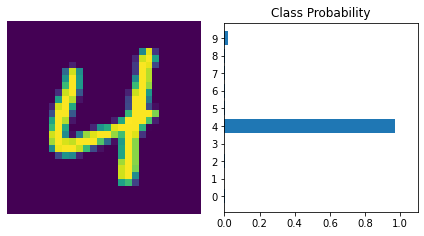

In [48]:
%matplotlib inline
import helper

images, labels = next(iter(trainloader))

img = images[0].view(1, 784)

# Turn off gradients to speed up this parat
with torch.no_grad():
    logps = model(img)
    
# Output of the network are log-probabilites, need to take exponential for probabilities
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)